# Data-Driven Used Car Price Prediction for Syari Mobil

## Background
Syari Mobil adalah sebuah dealer mobil bekas yang berfokus dalam jual-beli mobil di Arab Saudi.Syari Mobil memiliki tujuan ambisius untuk meningkatkan profitabilitas. Model bisnis utama perusahaan bergantung pada dua aktivitas kunci: mengakuisisi (membeli) mobil bekas dengan harga serendah mungkin dan menjualnya kembali dengan harga pasar yang wajar untuk memastikan perputaran inventaris yang cepat.

Saat ini, proses penentuan harga—baik untuk pembelian maupun penjualan—dilakukan sepenuhnya secara manual oleh agen di lapangan. Proses ini memiliki beberapa kelemahan signifikan:

- **Memakan Waktu**: Setiap mobil memerlukan riset pasar yang mendalam dan memakan waktu, yang memperlambat proses akuisisi.

- **Tidak Konsisten**: Penilaian sangat bergantung pada pengalaman dan intuisi masing-masing agen, yang dapat menyebabkan inkonsistensi harga di seluruh perusahaan.

- **Risiko Kesalahan**: Ada risiko yang melekat dalam penilaian manual, baik itu membeli mobil terlalu mahal (mengurangi margin keuntungan) atau menjualnya terlalu murah (kehilangan potensi pendapatan).

## Problem Statement

Untuk mengatasi inefisiensi dan risiko ini, Syari Mobil perlu beralih dari penilaian berbasis intuisi ke pendekatan yang lebih terstruktur dan berbasis data. Perusahaan membutuhkan sebuah alat yang dapat memberikan estimasi harga yang cepat, akurat, dan objektif kepada agen di lapangan.

## Tujuan

Tujuan dari proyek ini adalah untuk mengembangkan sebuah model machine learning untuk prediksi harga mobil bekas yang dapat digunakan oleh agen Syari Mobil. Model ini bertujuan untuk:

- **Memberikan Estimasi Harga Beli yang Optimal**: Membantu agen dalam menegosiasikan harga pembelian yang paling menguntungkan berdasarkan data pasar.

- **Menentukan Harga Jual yang Kompetitif**: Memberikan rekomendasi harga jual yang wajar agar mobil dapat terjual dengan cepat tanpa mengorbankan keuntungan.

- **Meningkatkan Efisiensi Operasional**: Mengurangi waktu yang dibutuhkan untuk riset manual, sehingga memungkinkan agen untuk mengakuisisi dan menjual lebih banyak mobil dalam waktu yang sama.

## Metrik Keberhasilan

**Mean Absolute Error (MAE)**

Untuk mengukur keberhasilan model, metrik utama yang akan digunakan adalah Mean Absolute Error (MAE). Pemilihan metrik ini sangat penting untuk konteks bisnis Syari Mobil:

- **Mudah Diinterpretasikan**: MAE mengukur rata-rata kesalahan prediksi dalam satuan mata uang yang sama (SAR). Ini memungkinkan kita untuk memberikan laporan yang jelas kepada agen dan manajemen, misalnya, "Rata-rata, prediksi harga model kita meleset sekitar X SAR."

- **Fokus pada Kesalahan Tipikal**: Berbeda dengan metrik lain yang cenderung memberi penalti besar pada kesalahan ekstrem, MAE lebih tahan terhadap pengaruh outlier. Hal ini sangat penting dalam konteks pasar mobil bekas, di mana terdapat mobil unik atau antik dengan harga sangat tinggi. Dengan menggunakan MAE, beberapa prediksi yang meleset pada mobil bernilai tinggi tidak akan secara signifikan mengaburkan kinerja model yang sudah baik pada mayoritas mobil di pasar.

## Dataset Features Description

- **Type**: Type of used car.
- **Region**: The region in which the used car was offered for sale.
- **Make**: The company name.
- **Gear_Type**: Gear type of the used car.
- **Origin**: Origin of the used car.
- **Options**: Options of the used car.
- **Year**: Manufacturing year.
- **Engine_Size**: The engine size of the used car.
- **Mileage**: Mileage of the used car.
- **Negotiable**: `True` if the price is 0, meaning the price is negotiable.
- **Price**: Selling price of the used car.


In [ ]:
# Imports
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for date conversions for calculating trip durations
from datetime import datetime
from datetime import date
from datetime import timedelta

# Impor untuk preprocessing dan modeling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
import sklearn.metrics as metrics # For confusion matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
import scipy.stats as st


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## EDA

### 1. Gambaran Umum Dataset

In [4]:
df = pd.read_csv("data_saudi_used_cars.csv")

In [5]:
# Fucntion for summary
def column_summary_plus(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes each column in a DataFrame and returns a summary of its properties.

    This improved version is faster, more accurate, and uses idiomatic pandas functions.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing a summary for each column.
    """
    results_list = []  # Use a list to store results, much faster than appending to a DF

    # Loop through each column in the DataFrame
    for column in df.columns:
        # --- Basic Information ---
        col_dtype = df[column].dtype
        num_nulls = df[column].isnull().sum()
        num_non_nulls = df[column].notnull().sum()
        
        # --- Distinct Values Analysis ---
        value_counts = df[column].value_counts()
        num_distinct_values = len(value_counts)
        top_10_distinct = dict(value_counts.head(10))

        # --- Initialize stats as None ---
        min_value, max_value, median, average, average_non_zero = [None] * 5

        # --- Numeric Column Analysis ---
        if pd.api.types.is_numeric_dtype(df[column]):
            # Drop NA values for statistical calculations
            col_non_null = df[column].dropna()
            
            if not col_non_null.empty:
                min_value = col_non_null.min()
                max_value = col_non_null.max()
                median = col_non_null.median()
                average = col_non_null.mean()

                # Calculate average of non-zero values correctly
                non_zero_values = col_non_null[col_non_null != 0]
                if not non_zero_values.empty:
                    average_non_zero = non_zero_values.mean()
                else:
                    average_non_zero = 0 # Or None, depending on desired output

        # --- For non-numeric columns, min/max can still be calculated if they are sortable ---
        elif not num_distinct_values == 0:
             try:
                sorted_values = sorted(value_counts.index)
                min_value = sorted_values[0]
                max_value = sorted_values[-1]
             except TypeError:
                # This occurs if the column has mixed types that can't be sorted
                min_value = "Unsortable"
                max_value = "Unsortable"


        # Append all info for the column as a dictionary to our list
        results_list.append({
            'col_name': column,
            'col_dtype': col_dtype,
            'nulls_num': num_nulls,
            'non_nulls_num': num_non_nulls,
            'null_present': 1 if num_nulls > 0 else 0,
            'num_distinct_values': num_distinct_values,
            'min_value': min_value,
            'max_value': max_value,
            'median_no_na': median,
            'average_no_na': average,
            'average_non_zero': average_non_zero,
            'distinct_values_top_10': top_10_distinct
        })
        
    # Create the final DataFrame from the list of dictionaries in one go
    return pd.DataFrame(results_list)

In [6]:
# Check summary of data
summary_df = column_summary_plus(df)
display(summary_df)

,col_name,col_dtype,nulls_num,non_nulls_num,null_present,num_distinct_values,min_value,max_value,median_no_na,average_no_na,average_non_zero,distinct_values_top_10
0,Type,object,0,5624,0,347,2,ِACTIS V80,NaN,NaN,NaN,"{'Land Cruiser': 269, 'Camry': 234, 'Hilux': 2..."
1,Region,object,0,5624,0,27,Abha,Yanbu,NaN,NaN,NaN,"{'Riyadh': 2272, 'Dammam': 925, 'Jeddah': 733,..."
2,Make,object,0,5624,0,58,Aston Martin,Škoda,NaN,NaN,NaN,"{'Toyota': 1431, 'Hyundai': 670, 'Ford': 530, ..."
3,Gear_Type,object,0,5624,0,2,Automatic,Manual,NaN,NaN,NaN,"{'Automatic': 4875, 'Manual': 749}"
4,Origin,object,0,5624,0,4,Gulf Arabic,Unknown,NaN,NaN,NaN,"{'Saudi': 4188, 'Gulf Arabic': 697, 'Other': 6..."
5,Options,object,0,5624,0,3,Full,Standard,NaN,NaN,NaN,"{'Full': 2233, 'Standard': 1822, 'Semi Full': ..."
6,Year,int64,0,5624,0,50,1963,2022,2016.0,2014.101885,2014.101885,"{2016: 847, 2017: 566, 2015: 554, 2018: 528, 2..."
7,Engine_Size,float64,0,5624,0,71,1.0,9.0,3.0,3.295430,3.295430,"{3.5: 511, 2.0: 440, 2.5: 439, 1.6: 411, 2.4: ..."
8,Mileage,int64,0,5624,0,1716,100,20000000,103000.0,150923.375000,150923.375000,"{300000: 90, 200000: 72, 300: 50, 100000: 38, ..."
9,Negotiable,bool,0,5624,0,2,False,True,0.0,0.319346,1.000000,"{False: 3828, True: 1796}"


Berdasarkan ringkasan diatas menunjukan bahwa:
- Terdapat 10 kolom yang dapat digunakan untuk memprediksi harga mobil bekas
- Hanya kolom `Year` yang memiliki tipe data yang tidak sesuai dan perlu dilakukan perubahan ke bentuk yang lebih sesuai (date)
- Tidak terdapat null value pada dataset ini sehingga tidak perlu dilakukan operasi dalam mengisi nilai null value
- Kolom `Origin` terdapat nilai **Unknown**, nilai ini perlu dianalisis lebih lanjut apakah nilai tersebut dikarenakan ketidaktersediaan data atau kategori tersebut benar-bener tidak diketahui. Untuk case kedua bisa kita masukan kedalam kategori lain seperti **Other**.
- Berdasarkan kolom 'Year' dataset ini memiliki rentang yang cukup luas mulai dari tahun 1963 hingga 2022.
- Kolom `Mileage` memiliki nilai maximum sebesar 20.000.000 ini merupakan nilai ekstream yang perlu dihapus dalam dataset karena merupakan sebuah kesalahan dalam penginputan.
- Kolom `Price` Mmemiliki nilai minimum 0, nilai tersebut menandakan bahwa mobil tersebut dapat dilakukan negosiasi jadi tidak terdapat nilai harga yang sebenarnya. Nilai ini perlu dikaji lebih lanjut karena dapat mempengaruhi hasil prediksi nantinya.

In [7]:
df.head()

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000
3,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0


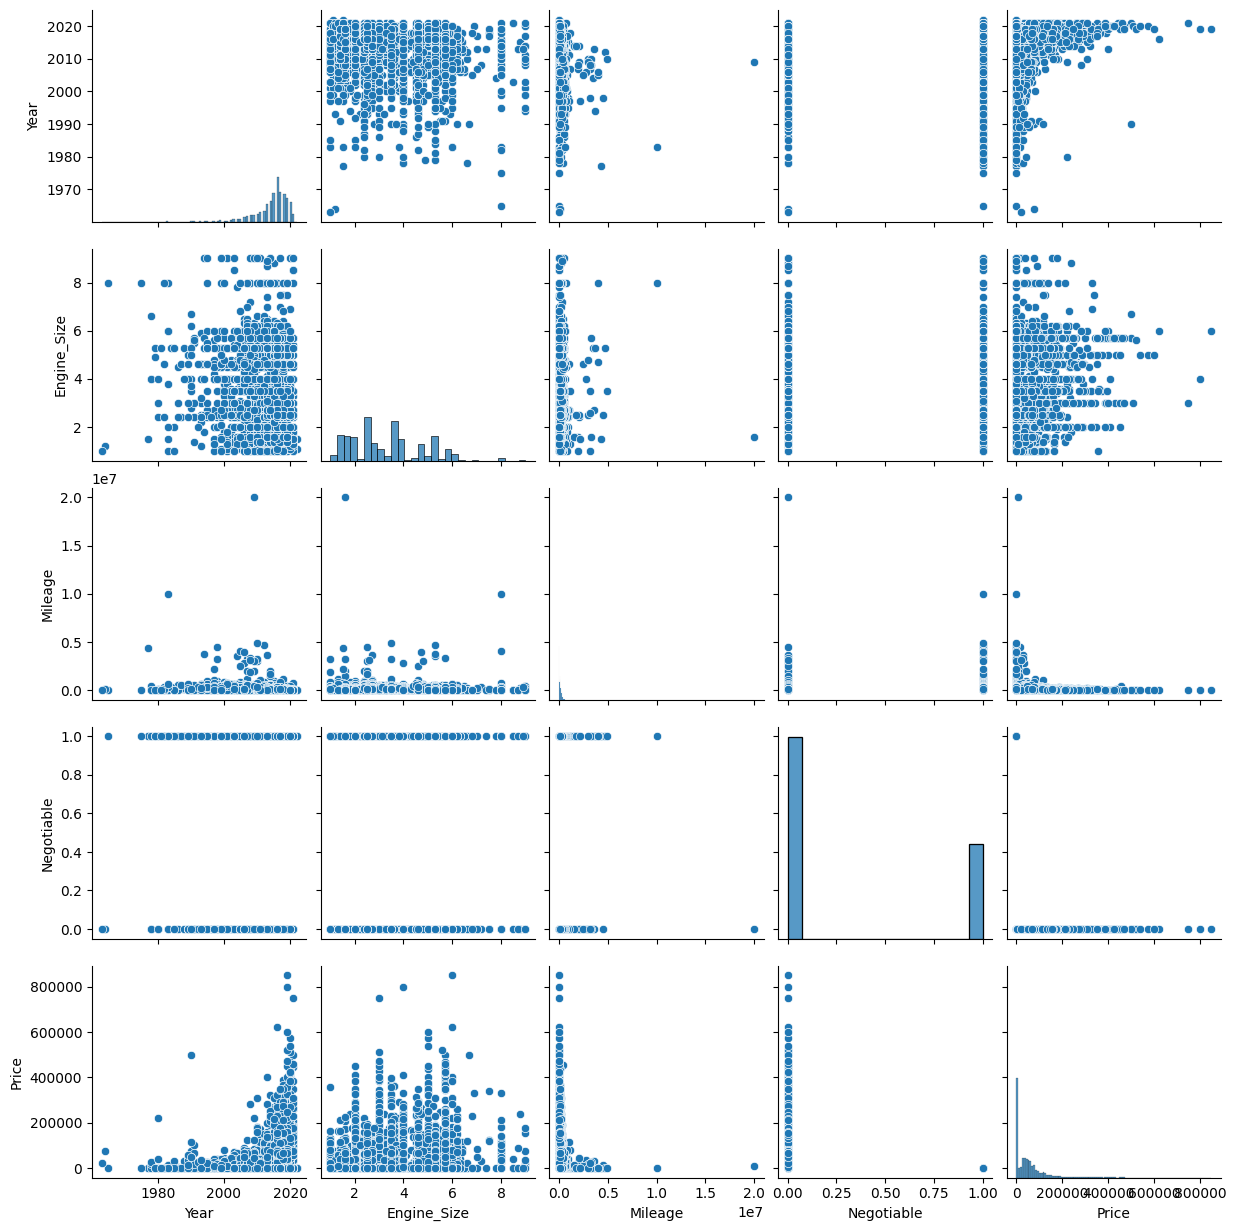

In [8]:
sns.pairplot(df)

### 2. Tantangan Utama Dataset

### 2A. Harga 0 (Nego)

In [9]:
# Check sum of the price is 0
df.query('Price == 0')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
4,FJ,Riyadh,Toyota,Automatic,Saudi,Full,2020,4.0,49000,True,0
9,LS,Aseer,Lexus,Automatic,Saudi,Full,1998,4.6,300,True,0
14,Hilux,Yanbu,Toyota,Automatic,Saudi,Full,2014,2.7,209,True,0
15,Land Cruiser,Aseer,Toyota,Manual,Gulf Arabic,Semi Full,1982,4.6,340000,True,0
...,...,...,...,...,...,...,...,...,...,...,...
5610,Town Car,Jeddah,Lincoln,Automatic,Other,Full,1999,5.0,343,True,0
5614,Victoria,Makkah,Ford,Automatic,Saudi,Standard,2010,4.6,345000,True,0
5617,Yukon,Jubail,GMC,Automatic,Saudi,Semi Full,2006,5.3,300,True,0
5620,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,0


Berdasarkan data diatas, pada kolom price terdapat nilai 0 yang menunjukan bahwa mobil tersebut bersifat nego. Sehingga tidak dicantumkan harga secara spesifik. Jika tidak dihandle hal ini akan mempengaruhi performa model nantinya>

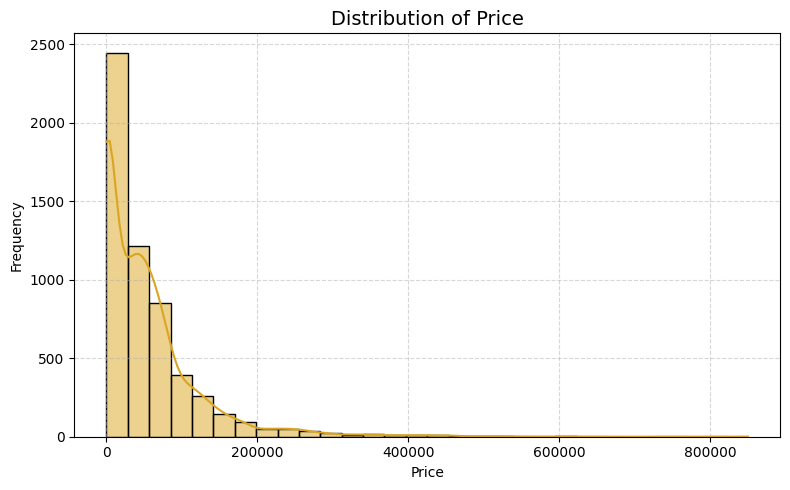

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], color='goldenrod', kde=True, bins=30)

plt.title('Distribution of Price', fontsize=14)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Grafik distribusi harga mobil bekas pada dataset ini cenderung memiliki pola skew kanan. Grafik tersebut juga menunjukan proporsi nilai 0 yang sangat tinggi, hal tersebut dikarenakan banyaknya harga mobil yang berstatus nego dan tidak dicantumkan harganya. Maka dari itu agar lebih relevant maka kita membuat distribusi `Price` kembali tanpa menggunakan nilai 0 untuk melihat persebarannya. 

### 2B. Distribusi Harga Tidak Normal

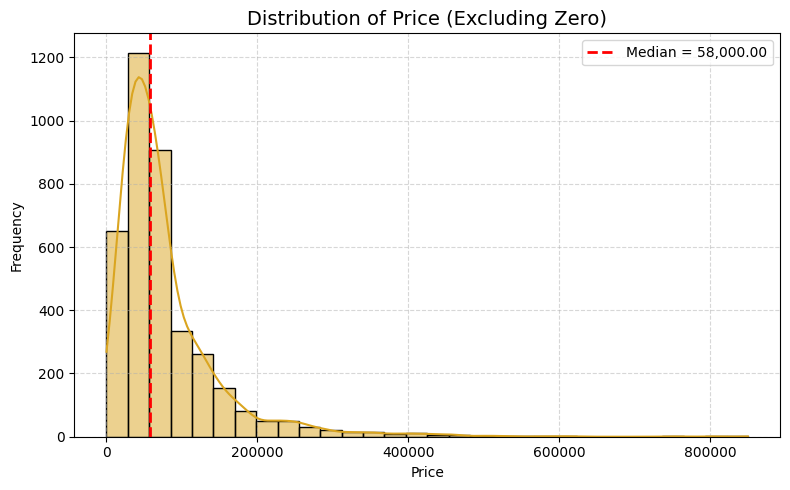

Median Price (excluding zero) = 58,000.00


In [11]:
# Filter data dan hitung median
price_no_zero = df[df['Price'] != 0]['Price']
median_price = price_no_zero.median()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(price_no_zero, color='goldenrod', kde=True, bins=30)

# Tambahkan garis median
plt.axvline(median_price, color='red', linestyle='--', linewidth=2, label=f'Median = {median_price:,.2f}')

# Judul & label
plt.title('Distribution of Price (Excluding Zero)', fontsize=14)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Median Price (excluding zero) = {median_price:,.2f}")

Berdasarkan persebaran grafik diatas menunjukan bahwa kolom `Price` memiliki pola distribusi yang lebih baik jika tidak memasukan mobil yang memiliki kategori nego (harga 0). Sedangkan untuk nilai ekstream yaitu lebih dari 400.000, terlihat jarang. Median pada mobil bekas pada data diatas juga lebih masuk akal yaitu 58.000 SAR (251 juta rupiah) jika dibanding ketika kita memasukan nilai 0 pada grafik atau dalam analisi yang menghasilkan median 37.000 SAR (160 juta rupiah). Maka perlu dilakukan imputasi pada kolom yang memiliki kategori negotable untuk meningkatkan kualitas dari model yang dihasilkan.

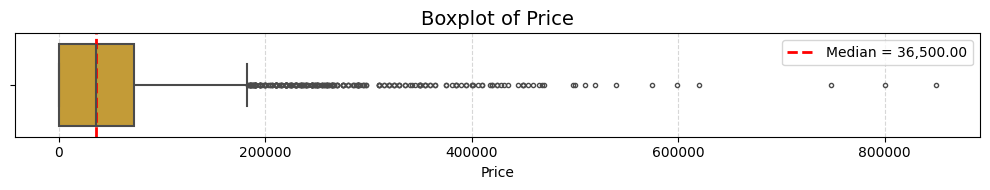

Median Price = 36,500.00


In [12]:
median_price = df['Price'].median()

plt.figure(figsize=(10, 2))
sns.boxplot(x=df['Price'], color='goldenrod', linewidth=1.5, fliersize=3)

# Garis median
plt.axvline(median_price, color='red', linestyle='--', linewidth=2, label=f'Median = {median_price:,.2f}')

plt.title('Boxplot of Price', fontsize=14)
plt.xlabel('Price')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Median Price = {median_price:,.2f}")

Kolom `Price` juga memiliki outlier yang ekstream, hal ini dikarenakan beberapa mobil yang termasuk kelas premium memiliki harga yang jauh dari harga standar mobil pada umumnya. Lalu ada mobil yang bersifat antik dan unik, walaupun mobil tersebut memiliki spesifikasi pada umumnya harga yang dibandrol akan lebih tinggi jauh berkali lipat dibanding mobil standard. Hal ini dapat menjadi penyebab utama dalam prediksi data ini, karena fitur yang digunakan kurang bisa menggambarkan harga sepenuhnya. Maka besar kemungkinan error yang dihasilkan pada saat prediksi akan tinggi.

In [13]:
# Cek jumlah mobil dibawah harga pasar wajar dan bukan 0
df.query('Price < 4000 and Price != 0').shape

(63, 11)

In [14]:
df.query('Price < 4000 and Price != 0')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
46,Elantra,Abha,Hyundai,Automatic,Saudi,Semi Full,2020,2.0,27000,False,1010
65,Malibu,Arar,Chevrolet,Automatic,Saudi,Standard,2021,1.5,24000,False,1200
304,Azera,Tabouk,Hyundai,Automatic,Saudi,Standard,2018,3.5,147,False,2049
356,Wingle,Jeddah,Great Wall,Manual,Saudi,Full,2020,2.0,73000,False,1197
396,K5,Aseer,Kia,Automatic,Saudi,Standard,2021,2.5,30000,False,1414
423,Elantra,Riyadh,Hyundai,Automatic,Saudi,Semi Full,2020,2.0,47000,False,1221
496,Camry,Hafar Al-Batin,Toyota,Automatic,Saudi,Semi Full,2020,2.5,53800,False,1700
596,Sonata,Jeddah,Hyundai,Automatic,Saudi,Full,2020,2.5,17000,False,1430
714,Victoria,Riyadh,Ford,Automatic,Saudi,Full,2001,4.6,399249,False,3000
789,CX5,Khobar,Mazda,Automatic,Saudi,Standard,2021,2.5,5500,False,1262


Beberapa mobil juga memiliki nilai yang tidak wajar yaitu kurang dari 4000 SAR (17 juta rupiah). Hal ini bisa saja terjadi untuk mobil yang sudah usang dan memiliki umur yang sangat tua (lebih dari 20 tahun). Namun berdasarkan data diatas menunjukan bahwa mobil yang memili harga kurang dari 4000 SAR tersebut memiliki usia yang terbilang masih baru (kurang dari 10 tahun). 

Asumsi kenapa hal tersebut bisa terjadi yaitu:
- Kesalahan dalam input data : seperti salah menginput 20.000 malah menginput 200
- Placeholder: Beberapa penjual mungkin menggunakan harga yang rendah tersebut untuk menarik pelanggan mengklik iklan tersebut

Maka data tersebut sebaiknya dilakukan filtrasi agar model yang dihasilkan dapat dipertanggung jawabkan hasilnya.

In [15]:
# Filter hanya untuk harga diatas 4000 SAR dan harga 0
df = df[~((df['Price'] < 4000) & (df['Price'] != 0))]

Berdasarkan kesimpulan distribusi dan karakteristik kolom `Price` diatas, kolom tersebut memiliki distribusi yang tidak normal dan memiliki outlier yang ekstream. Hal tersebut akan mempengaruhi kinerja model nantinya. maka perlu dilakukan feature enginering agar kualitas dari data yang dimiliki meningkat. Beberapa model matematika dapat membantu meningkatkan kualitas data dan berdampak terhadap peningkatan model dalam memprediksi harga. 

Berdasarkan artikel [Interpreting Log Transformations in a Linear Model](https://library.virginia.edu/data/articles/interpreting-log-transformations-in-a-linear-model?utm_source=chatgpt.com) Tranformasi logaritma dapat membantu dalam mengatasi data skew. Tranformasi logaritma dapat mengumpulkan data yang menyebar membuatnya menjadi berkumpul sehingga dapat membuat distribusi menjadi "normal" atau simetris.

In [16]:
# Make a logarithmic Price
df['Price_log'] = np.log1p(df['Price'])

/var/folders/9m/2npf62r547796blh6s6fvmwr0000gn/T/ipykernel_79792/3729484201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price_log'] = np.log1p(df['Price'])


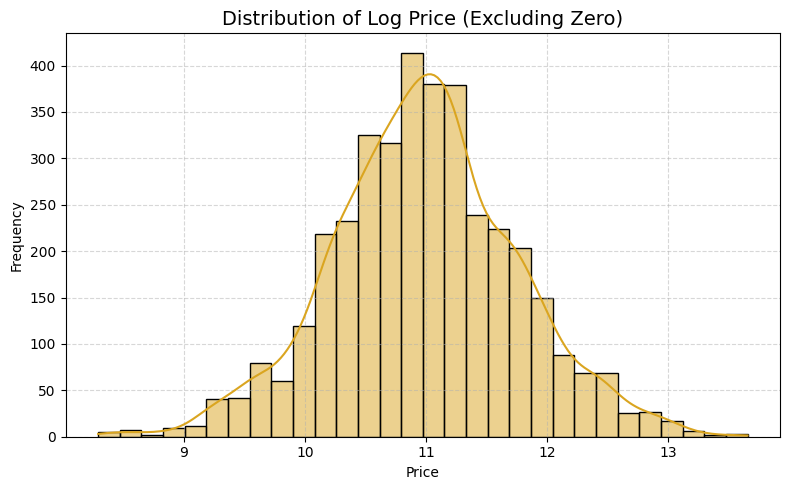

In [17]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df['Price_log'] != 0]['Price_log'], color='goldenrod', kde=True, bins=30)

plt.title('Distribution of Log Price (Excluding Zero)', fontsize=14)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 2C. Outlier Ekstream

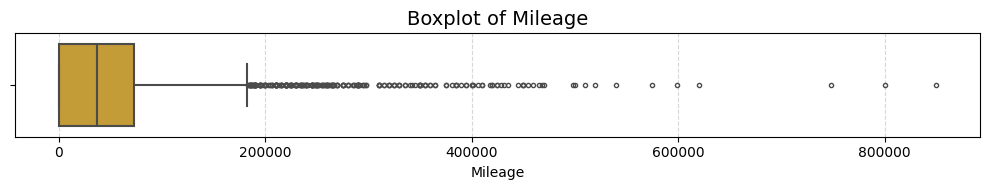

In [18]:
# Cek Outlier pada Kolom Mileage
plt.figure(figsize=(10, 2))
sns.boxplot(x=df['Price'], color='goldenrod', linewidth=1.5, fliersize=3)

plt.title('Boxplot of Mileage', fontsize=14)
plt.xlabel('Mileage')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [19]:
# Filter kolom mileage dan menghapus nilai eksteam
df = df[df['Mileage'] < 1000000].copy()

### 2D. Kardinalitas Tinggi

In [20]:
df['Type'].value_counts()

Type
Land Cruiser           266
Camry                  230
Hilux                  205
Accent                 174
Yukon                  160
Sonata                 150
Tahoe                  146
Taurus                 143
Elantra                125
Expedition             107
Corolla                107
Furniture               94
Suburban                87
Patrol                  79
Prado                   78
Accord                  77
S                       76
ES                      75
Range Rover             74
Sunny                   72
Yaris                   71
LX                      71
Pajero                  71
Sierra                  61
Land Cruiser Pickup     59
FJ                      57
Datsun                  57
Charger                 57
Caprice                 56
Innova                  53
Marquis                 50
Senta fe                48
C                       47
Azera                   44
H1                      44
6                       43
Optima                 

In [21]:
df['Make'].value_counts()

Make
Toyota          1412
Hyundai          647
Ford             523
Chevrolet        447
Nissan           384
GMC              277
Kia              243
Mercedes         225
Lexus            222
Mazda            127
Honda            115
BMW               97
Mitsubishi        93
Dodge             92
Land Rover        78
Jeep              54
Chrysler          50
Audi              38
Changan           36
Renault           34
Cadillac          31
Genesis           30
Isuzu             25
Geely             24
Volkswagen        22
Porsche           21
MG                18
Suzuki            16
Lincoln           16
INFINITI          15
HAVAL             14
MINI              11
Jaguar             9
Mercury            9
Other              9
Daihatsu           9
Peugeot            8
Fiat               7
Hummer             5
FAW                4
Bentley            4
GAC                3
Rolls-Royce        3
Great Wall         3
Maserati           3
Zhengzhou          2
Aston Martin       2
Foton   

In [22]:
df['Type'].nunique()

344

Kolom `Type` memiliki cardinality atau variasi yang sangat tinggi, sehingga jika kita tidak menangani hal ini, fitur yang muncul pada saat melakukan encoding akan sangat banyak dan hal ini dapat mempengaruhi kinerja model. Maka dari itu perlu dilakukan pendekatan yang relevant. Ada beberapa pendekatan yaitu menggunakan fitur yang memiliki jumlah kemunculan tertinggi misal top 10 atau top 20 type paling banyak muncul, sisanya dapat dihapus. Mengutip pada [AWinning the KDD Cup Orange Challenge with Ensemble Selection 2009](https://proceedings.mlr.press/v7/) yang menggunakan cara yang sama yaitu menggunakan 10 kategori paling berpengaruh dapat meningkatkan hasil dari prediksi model. Namun cara ini juga memiliki kelemahan yaitu model akan lemah dalam memprediksi kategori diluar dari Top N tersebut. Maka solusi yang saya lakukan adalah memfilter kategori dengan 20 kategori paling berpengaruh dan sisanya akan dimasukan kedalam kategori baru yaitu **Others**. Cara ini bisa disebut dengan lumping atau Grouping of Rare Categories. 

In [23]:
def lump_categories(dataframe, column_name, top_n=10):
    """
    Mengelompokkan kategori yang jarang muncul dalam sebuah kolom ke dalam 'Other'.

    Args:
        dataframe (pd.DataFrame): DataFrame input.
        column_name (str): Nama kolom yang akan di-lump.
        top_n (int): Jumlah kategori teratas yang akan dipertahankan.
    
    Returns:
        pd.DataFrame: DataFrame dengan kolom baru yang sudah di-lump.
    """
    # Tentukan N kategori teratas
    top_categories = dataframe[column_name].value_counts().nlargest(top_n).index
    
    # Buat nama kolom baru
    new_column_name = f"{column_name}_Lumped"
    
    # Gunakan np.where untuk membuat kolom baru yang sudah dikelompokkan
    dataframe[new_column_name] = np.where(
        dataframe[column_name].isin(top_categories), 
        dataframe[column_name], 
        'Other'
    )
    
    print(f"--- Hasil Lumping untuk Kolom: {column_name} (Top {top_n}) ---")
    print(dataframe[new_column_name].value_counts())
    print("-" * 50)
    
    return dataframe

In [24]:
# 1. Lumping untuk kolom 'Type' (mempertahankan 20 teratas)
df = lump_categories(df, 'Type', top_n=20)

# 2. Lumping untuk kolom 'Make' (mempertahankan 15 teratas)
df = lump_categories(df, 'Make', top_n=15)

# 3. Lumping untuk kolom 'Region' (mempertahankan 10 teratas)
df = lump_categories(df, 'Region', top_n=10)

--- Hasil Lumping untuk Kolom: Type (Top 20) ---
Type_Lumped
Other           3004
Land Cruiser     266
Camry            230
Hilux            205
Accent           174
Yukon            160
Sonata           150
Tahoe            146
Taurus           143
Elantra          125
Expedition       107
Corolla          107
Furniture         94
Suburban          87
Patrol            79
Prado             78
Accord            77
S                 76
ES                75
Range Rover       74
Sunny             72
Name: count, dtype: int64
--------------------------------------------------
--- Hasil Lumping untuk Kolom: Make (Top 15) ---
Make_Lumped
Toyota        1412
Hyundai        647
Other          547
Ford           523
Chevrolet      447
Nissan         384
GMC            277
Kia            243
Mercedes       225
Lexus          222
Mazda          127
Honda          115
BMW             97
Mitsubishi      93
Dodge           92
Land Rover      78
Name: count, dtype: int64
------------------------------

##  Data Preparation & Feature Engineering 

### 3. Data Cleaning

In [25]:
# Cek jumlah duplikat
df.duplicated().sum()

np.int64(4)

In [26]:
# Cek duplikat
df[df.duplicated(keep=False)]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Price_log,Type_Lumped,Make_Lumped,Region_Lumped
236,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910,11.196995,Sonata,Hyundai,Jeddah
540,Rio,Riyadh,Kia,Automatic,Saudi,Standard,2016,1.4,270000,False,25000,10.126671,Other,Kia,Riyadh
953,Rio,Riyadh,Kia,Automatic,Saudi,Standard,2016,1.4,270000,False,25000,10.126671,Other,Kia,Riyadh
2012,Tucson,Dammam,Hyundai,Automatic,Saudi,Standard,2016,2.0,155000,False,45000,10.714440,Other,Hyundai,Dammam
3631,Camry,Riyadh,Toyota,Automatic,Saudi,Full,2013,2.5,185000,True,0,0.000000,Camry,Toyota,Riyadh
4646,Sonata,Jeddah,Hyundai,Automatic,Saudi,Standard,2020,2.4,100,False,72910,11.196995,Sonata,Hyundai,Jeddah
4933,Tucson,Dammam,Hyundai,Automatic,Saudi,Standard,2016,2.0,155000,False,45000,10.714440,Other,Hyundai,Dammam
5267,Camry,Riyadh,Toyota,Automatic,Saudi,Full,2013,2.5,185000,True,0,0.000000,Camry,Toyota,Riyadh


Terdapat data duplikat pada dataset ini, hal ini bisa jadi dikarenakan penjual mengiklankan mobil sebanyak 2 kali untuk meningkatkan peluang mobil tersebut terjual. Maka dari itu bisa kita hapus data duplikat ini dikarenakan jumlahnya pun terbilang sangat sedikit.

In [27]:
# Hapus data duplicate
df = df.drop_duplicates()

### 4. New Feature Creation

Dataset ini memiliki kolom 'Year' yang menunjukan tahun pembuatan mobil tersebut. Dari dateset tersebut bisa dibuat kolom baru yaitu `Car_Age` atau usia mobil dan lebih relevant sebagai fitur dibanding berupa tahun saja.

In [28]:
# Convert to Datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

In [29]:
# Ambil hanya Tahun
df['Year'] = df['Year'].dt.year

In [30]:
# Buat fitur Car_Age (karena ini kemungkinan besar penting)
current_year = datetime.now().year
df['Car_Age'] = current_year - df['Year']

In [31]:
# Cek mobil yang memiliki usia lebih dari 30 tahun
df.query('Car_Age > 30')

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Price_log,Type_Lumped,Make_Lumped,Region_Lumped,Car_Age
15,Land Cruiser,Aseer,Toyota,Manual,Gulf Arabic,Semi Full,1982,4.6,340000,True,0,0.000000,Land Cruiser,Toyota,Aseer,43
16,Land Cruiser,Al-Baha,Toyota,Manual,Saudi,Semi Full,1985,2.0,30000,True,0,0.000000,Land Cruiser,Toyota,Other,40
19,Caprice,Riyadh,Chevrolet,Automatic,Other,Standard,1983,1.0,500000,True,0,0.000000,Other,Chevrolet,Riyadh,42
62,SEL,Tabouk,Mercedes,Automatic,Saudi,Full,1986,3.0,500000,False,5500,8.612685,Other,Mercedes,Tabouk,39
113,SEL,Riyadh,Mercedes,Automatic,Other,Full,1991,5.5,160000,True,0,0.000000,Other,Mercedes,Riyadh,34
254,Suburban,Abha,GMC,Automatic,Other,Standard,1993,5.9,442050,True,0,0.000000,Suburban,GMC,Other,32
290,S,Al-Jouf,Mercedes,Automatic,Other,Full,1993,3.0,138,False,22000,9.998843,S,Mercedes,Other,32
306,Land Cruiser Pickup,Aseer,Toyota,Manual,Saudi,Standard,1983,1.5,2580,False,15000,9.615872,Other,Toyota,Aseer,42
434,SEL,Dammam,Mercedes,Automatic,Other,Full,1990,4.0,89000,False,75000,11.225257,Other,Mercedes,Dammam,35
617,Thunderbird,Riyadh,Ford,Automatic,Other,Full,1965,8.0,25000,True,0,0.000000,Other,Ford,Riyadh,60


Harga mobil bekas cenderung berfluktuasi secara unik. Beberapa model justru mengalami kenaikan nilai seiring bertambahnya usia, terutama jika memiliki tipe, kondisi, atau karakteristik yang langka. Namun, tidak semua mobil tua akan mengalami peningkatan harga. Pada dataset ini terdapat mobil-mobil berusia cukup lama, yang berpotensi menjadi tantangan saat pelatihan model. Model cenderung mempelajari pola hanya dari fitur yang tersedia, seperti `Mileage`, `Type`, atau `Engine Size`. Akibatnya, bisa timbul kesalahan prediksi yang besar misalnya, mobil tua dengan harga tinggi tetapi spesifikasi dan karakteristiknya kalah dibanding mobil modern karena model tidak mampu menangkap faktor keunikan yang tidak terwakili dalam fitur.

Maka agar model dapat menangkap pola keunikan dari mobil yang memiliki usia yang tua, dibuatkan fitur baru baru yaitu kolom `is_classic` yang memisahkan mobil yang memiliki tipe classic dan modern. Semoga model dapat menangkap pola dari keunikan mobil classic ini.

In [ ]:
# --- 1. Membuat Kolom 'is_classic' ---
# Mendefinisikan mobil sebagai "klasik" jika usianya lebih dari 25 tahun.
classic_age_threshold = 25
df['is_classic'] = np.where(df['Car_Age'] > classic_age_threshold, 1, 0)

print(f"--- Jumlah Mobil Klasik (Usia > {classic_age_threshold} tahun) ---")
print(df['is_classic'].value_counts())

--- Jumlah Mobil Klasik (Usia > 25 tahun) ---
is_classic
0    5367
1     158
Name: count, dtype: int64


Kita asumsikan bahwa mobil classic yaitu memiliki usia lebih dari 25 tahun. Berdasarkan data diatas jumlah mobil classic terdapat 158 dibanding mobil moderen sebanyak 5367.

### Membuat Kolom 'car_class'

In [33]:
 
# Mendefinisikan daftar merek untuk setiap kelas
luxury_makes = [
    'Rolls-Royce', 'Bentley', 'Ferrari', 'Lamborghini', 'McLaren', 
    'Aston Martin', 'Maserati', 'Porsche'
]

premium_makes = [
    'Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Jaguar', 
    'Land Rover', 'Cadillac', 'Genesis', 'Lincoln', 'Infiniti'
]

# Membuat kondisi untuk np.select
conditions = [
    df['Make'].isin(luxury_makes),
    df['Make'].isin(premium_makes)
]

In [34]:
# Pilihan nilai untuk setiap kondisi
choices = ['Luxury', 'Premium']

In [35]:
# Buat kolom baru, dengan 'Standard' sebagai nilai default
df['car_class'] = np.select(conditions, choices, default='Standard')

print("--- Distribusi Kelas Mobil ---")
print(df['car_class'].value_counts())
print("-" * 50)

--- Distribusi Kelas Mobil ---
car_class
Standard    4970
Premium      521
Luxury        34
Name: count, dtype: int64
--------------------------------------------------


### Rasio Jarak Tempur berdasarkan Usia mobil

Secara sederhana, fitur ini mengukur intensitas penggunaan rata-rata sebuah mobil per tahun. Fitur ini menjawab pertanyaan bisnis yang sangat penting: "Seberapa sering mobil ini digunakan sepanjang hidupnya?"

Rumus Perhitungannya: `Mileage_per_Age = Total Jarak Tempuh / (Usia Mobil + 1)`

(Catatan: + 1 ditambahkan untuk menghindari pembagian dengan nol jika ada mobil yang usianya kurang dari satu tahun, di mana Car_Age bisa menjadi 0).

In [ ]:
# Membuat fitur Mileage/Age
df['Mileage_per_Age'] = df['Mileage'] / (df['Car_Age'] + 1)

Mobil berusia 5 tahun dengan jarak 50.000 km memiliki pola penggunaan yang berbeda dari mobil berusia 5 tahun dengan jarak 200.000 km. Fitur ini menangkap "intensitas penggunaan" mobil.

### Price Deviation by Make

kolom ini mengukur seberapa jauh harga sebuah mobil menyimpang dari harga rata-rata untuk merek (Make) mobil tersebut. Kolom ini menjawab pertanyaan: "Apakah Toyota Camry ini lebih mahal atau lebih murah dibandingkan dengan rata-rata harga semua mobil Toyota lainnya di dataset?"

Rumus Perhitungannya: Price_Deviation_by_Make = `Harga Mobil Saat Ini - Rata-rata Harga Semua Mobil dengan Merek yang Sama`.

Fitur ini diharapkan dapat menangkap pola dari variasi harga mobil yang memiliki tipe dan merk yang sama. Pola-pola tersebut seperti kondisi low mileage atau mobil masih dalam keadaan mulus, Good Deals ketika penjual ingin segera mobil tersebut laku, atau mobil istimewa edisi khusus. 

In [37]:
# Hitung rata-rata harga per merek
avg_price_by_make = df.groupby('Make')['Price'].transform('mean')
df['Price_Deviation_by_Make'] = df['Price'] - avg_price_by_make

Seberapa "mahal" atau "murah" sebuah mobil dibandingkan dengan rata-rata mobil lain dengan merek yang sama? Fitur ini bisa membantu model mengidentifikasi penawaran yang bagus atau mobil yang harganya terlalu tinggi.

In [ ]:
# Polynomial Features
df['Car_Age_Sq'] = df['Car_Age']**2

Hubungan antara fitur numerik dan harga tidak selalu lurus (linear). Misalnya, depresiasi mobil mungkin lebih cepat di tahun-tahun awal dan melambat seiring waktu.

## Handle 0 value in Price

### 5. Model Regresi (Imputasi Prediktif)

Kolom Price memiliki jumlah nilai 0 yang cukup banyak, yang menandakan harga mobil tersebut bersifat "nego". Salah satu pendekatan yang paling mungkin dilakukan adalah imputasi. Salah satu proses imputasi yang bisa dilakukan adalah machine learning.
Pendekatan ini jauh lebih unggul dibandingkan metode sederhana seperti mengisi nilai nol dengan rata-rata atau median. Alasannya, imputasi machine learning tidak hanya menggunakan satu nilai statistik, tetapi memanfaatkan hubungan dan pola dari semua fitur lain (`Make`,`Type`,`Year`, `Mileage`, dll.) untuk membuat "tebakan" yang cerdas dan kontekstual untuk setiap mobil.

Prosesnya dapat diuraikan sebagai berikut:
1. **Pemisahan Data**: Dataset dibagi menjadi dua kelompok:
Data Latih (Training Set): Terdiri dari semua mobil yang memiliki harga tercatat (harga > 0).
Data Prediksi (Prediction Set): Terdiri dari semua mobil yang harganya 0 (nego).

2. **Pelatihan Model Imputasi**: Sebuah model regresi (dalam kasus ini, Random Forest Regressor) dilatih hanya menggunakan data latih. Model ini belajar memahami pola kompleks antara fitur-fitur mobil dengan harga jualnya. Misalnya, ia belajar bagaimana kombinasi merek Toyota, tipe Land Cruiser, dan usia 5 tahun memengaruhi harga.
3. **Prediksi Harga yang Hilang**: Model yang sudah terlatih tersebut kemudian digunakan untuk memprediksi hargapada data prediksi. Karena model sudah "paham" hubungan antar fitur, ia dapat memberikan estimasi harga yang realistis untuk setiap mobil yang harganya nol, berdasarkan spesifikasinya masing-masing.
4. **Penggabungan Kembali**: Terakhir, nilai-nilai nol pada kolom Price di dataset asli digantikan dengan harga yang telah diprediksi. Hasilnya adalah sebuah dataset yang lengkap, di mana semua mobil kini memiliki nilai harga yang wajar dan siap digunakan untuk melatih model prediksi akhir.

Dengan cara ini, kita tidak hanya mengisi data yang hilang, tetapi juga memastikan bahwa nilai yang diimputasi relevan dan sesuai dengan karakteristik unik dari setiap mobil, yang pada akhirnya akan menghasilkan model prediksi yang lebih akurat dan andal.


In [39]:
# --- 2. Pisahkan Data untuk Imputasi ---
df_harga = df[df['Price'] > 0].copy()
df_nego = df[df['Price'] == 0].copy()

In [40]:
print(f"Data dengan harga: {len(df_harga)} baris")
print(f"Data tanpa harga (nego): {len(df_nego)} baris")

Data dengan harga: 3745 baris
Data tanpa harga (nego): 1780 baris


In [41]:
# --- 3. Siapkan Data untuk Model Imputasi ---
# Fitur (X) dan Target (y) dari data yang memiliki harga
X_impute_train = df_harga.drop(columns=['Price', 'Year','Make' ,'Region' ,'Type', 'Negotiable','Car_Age'])
y_impute_train = df_harga['Price']

In [42]:
# --- 4. Buat dan Latih Pipeline untuk Imputasi ---
# Definisikan kolom numerik dan kategorikal
numerical_cols = X_impute_train.select_dtypes(include=np.number).columns
categorical_cols = X_impute_train.select_dtypes(include=['object']).columns

In [43]:
# Buat preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

In [44]:
# Buat pipeline dengan RandomForestRegressor
imputation_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [45]:
# Latih pipeline pada data yang memiliki harga
print("\nMelatih model untuk imputasi...")
imputation_pipeline.fit(X_impute_train, y_impute_train)
print("Model imputasi selesai dilatih.")


Melatih model untuk imputasi...
Model imputasi selesai dilatih.


In [46]:
# Fitur (X) dari data yang harganya akan diprediksi
X_impute_predict = df_nego.drop(columns=['Price', 'Year', 'Type', 'Negotiable'])

In [47]:
# --- 5. Prediksi Harga yang Hilang ---
print("Memprediksi harga untuk data 'nego'...")
predicted_prices = imputation_pipeline.predict(X_impute_predict)

Memprediksi harga untuk data 'nego'...


In [48]:
# Masukkan harga yang diprediksi ke dalam DataFrame df_nego
df_nego['Price'] = predicted_prices
print("Prediksi selesai.")

Prediksi selesai.


In [49]:
# --- 6. Gabungkan Kembali Dataset ---
df_final = pd.concat([df_harga, df_nego], ignore_index=True)

print(f"\nJumlah data setelah imputasi: {len(df_final)} baris")
print("\nDeskripsi statistik kolom 'Price' setelah imputasi:")
print(df_final['Price'].describe())


Jumlah data setelah imputasi: 5525 baris

Deskripsi statistik kolom 'Price' setelah imputasi:
count      5525.000000
mean      55284.022262
std       69430.474922
min        4000.000000
25%        4370.000000
50%       38000.000000
75%       74000.000000
max      850000.000000
Name: Price, dtype: float64


Hasil dari proses imputasi dengan random forest regressor berhasil mengimputasi nilai 0 pada kolom `Price` yang menunjukan bahwa mobil tersebut bersifat negotable. Median dari kolom `Price` setelah imputasi mendekati median yaitu 38.000 hal ini mendekati median sebelum dilakukan imputasi yaitu 36.600.

In [51]:
# Make a logarithmic Price
df_final['Price_log'] = np.log1p(df_final['Price'])

In [50]:
df_final

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price,Price_log,Type_Lumped,Make_Lumped,Region_Lumped,Car_Age,is_classic,car_class,Mileage_per_Age,Price_Deviation_by_Make,Car_Age_Sq
0,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000.0,11.695255,Yukon,GMC,Riyadh,11,0,Standard,6666.666667,74063.718412,121
1,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000.0,12.468441,Range Rover,Land Rover,Riyadh,10,0,Premium,12727.272727,71429.487179,100
2,Optima,Hafar Al-Batin,Kia,Automatic,Saudi,Semi Full,2015,2.4,220000,False,42000.0,10.645449,Other,Kia,Other,10,0,Standard,20000.000000,9730.371901,100
3,CX3,Abha,Mazda,Automatic,Saudi,Semi Full,2019,2.0,25000,False,58000.0,10.968216,Other,Mazda,Other,6,0,Standard,3571.428571,10779.527559,36
4,Cayenne S,Riyadh,Porsche,Automatic,Saudi,Full,2012,4.8,189000,False,85000.0,11.350418,Other,Other,Riyadh,13,0,Luxury,13500.000000,-34666.666667,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520,Town Car,Jeddah,Lincoln,Automatic,Other,Full,1999,5.0,343,True,4400.0,0.000000,Other,Other,Jeddah,26,1,Premium,12.703704,-41843.750000,676
5521,Victoria,Makkah,Ford,Automatic,Saudi,Standard,2010,4.6,345000,True,4270.0,0.000000,Other,Ford,Makkah,15,0,Standard,21562.500000,-37644.537285,225
5522,Yukon,Jubail,GMC,Automatic,Saudi,Semi Full,2006,5.3,300,True,4285.0,0.000000,Yukon,GMC,Other,19,0,Standard,15.000000,-45936.281588,361
5523,Altima,Jeddah,Nissan,Automatic,Saudi,Semi Full,2020,2.5,58000,True,4340.0,0.000000,Other,Nissan,Jeddah,5,0,Standard,9666.666667,-34575.520833,25


Setelah dilakukan cleaning dan feature enginering, dataset ini memiliki 5.525 data dari sebelumnya 5624 dan memiliki 21 fitur dari sebelumnya 11 fitur. Diharapkan dataset ini dapat menangkap pola yang tersembunyi dari penentuan harga mobil bekas dan menghindari bias yang dihasilkan oleh model nantinya.

## Pemodelan & Evaluasi 

In [52]:
# Remove the target column from the features
X = df_final.drop(columns=['Price_log','Price', 'Year', 'Type','Region','Make', 'Negotiable','Car_Age'])

# Set y variable
y = df_final['Price_log']

# Display first few rows
display(X, y)

,Gear_Type,Origin,Options,Engine_Size,Mileage,Type_Lumped,Make_Lumped,Region_Lumped,is_classic,car_class,Mileage_per_Age,Price_Deviation_by_Make,Car_Age_Sq
0,Automatic,Saudi,Full,8.0,80000,Yukon,GMC,Riyadh,0,Standard,6666.666667,74063.718412,121
1,Automatic,Gulf Arabic,Full,5.0,140000,Range Rover,Land Rover,Riyadh,0,Premium,12727.272727,71429.487179,100
2,Automatic,Saudi,Semi Full,2.4,220000,Other,Kia,Other,0,Standard,20000.000000,9730.371901,100
3,Automatic,Saudi,Semi Full,2.0,25000,Other,Mazda,Other,0,Standard,3571.428571,10779.527559,36
4,Automatic,Saudi,Full,4.8,189000,Other,Other,Riyadh,0,Luxury,13500.000000,-34666.666667,169
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5520,Automatic,Other,Full,5.0,343,Other,Other,Jeddah,1,Premium,12.703704,-41843.750000,676
5521,Automatic,Saudi,Standard,4.6,345000,Other,Ford,Makkah,0,Standard,21562.500000,-37644.537285,225
5522,Automatic,Saudi,Semi Full,5.3,300,Yukon,GMC,Other,0,Standard,15.000000,-45936.281588,361
5523,Automatic,Saudi,Semi Full,2.5,58000,Other,Nissan,Jeddah,0,Standard,9666.666667,-34575.520833,25


0       11.695255
1       12.468441
2       10.645449
3       10.968216
4       11.350418
          ...    
5520     8.389587
5521     8.359603
5522     8.363109
5523     8.375860
5524     8.371242
Name: Price_log, Length: 5525, dtype: float64

Create training and testing sets. The test set should contain 20% of the total samples. Set `random_state=0`.

In [53]:
# Create training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Membuat pipeline dan Tranformasi Data

In [54]:
# Identifikasi kolom numerik dan kategorikal
numerical_cols = X_train.select_dtypes(include=np.number).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

In [55]:
# Buat pipeline untuk transformasi data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

### 6a. Pemilihan Model

In [56]:
print("--- Memulai Perbandingan Model ---")
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    # Buat pipeline lengkap untuk setiap model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Lakukan 5-fold cross-validation
    scores = cross_val_score(model_pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    
    # Ambil nilai absolut dan rata-ratakan untuk mendapatkan MAE (pada skala log)
    final_mae_log = np.mean(np.abs(scores))
    results[name] = final_mae_log
    print(f"Model: {name} | Rata-rata MAE (skala log): {final_mae_log:.4f}")

--- Memulai Perbandingan Model ---
Model: Linear Regression | Rata-rata MAE (skala log): 0.6400
Model: Ridge | Rata-rata MAE (skala log): 0.6402
Model: Lasso | Rata-rata MAE (skala log): 1.1780
Model: K-Neighbors Regressor | Rata-rata MAE (skala log): 0.5092
Model: Random Forest | Rata-rata MAE (skala log): 0.0657
Model: Gradient Boosting | Rata-rata MAE (skala log): 0.1048
Model: XGBoost | Rata-rata MAE (skala log): 0.0639
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 980
[LightGBM] [Info] Number of data points in the train set: 3536, number of used features: 65
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

/opt/anaconda3/envs/attritionpy312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/attritionpy312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/attritionpy312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/attritionpy312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/attritionpy312/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, 

In [57]:
sorted_results = sorted(results.items(), key=lambda item: item[1])

# Simpan hasil ke dalam DataFrame untuk visualisasi yang lebih baik
results_df = pd.DataFrame(sorted_results, columns=['Model', 'Mean Absolute Error (Log)'])

# Tampilkan DataFrame
display(results_df)

# Tentukan model terbaik secara otomatis dari hasil
best_model_name = results_df.iloc[0, 0]
print(f"\nModel terbaik adalah: {best_model_name}")

,Model,Mean Absolute Error (Log)
0,XGBoost,0.063949
1,Random Forest,0.065738
2,LightGBM,0.077031
3,Gradient Boosting,0.104811
4,K-Neighbors Regressor,0.509248
5,Linear Regression,0.639991
6,Ridge,0.640237
7,Lasso,1.177962



Model terbaik adalah: XGBoost


In [58]:
# Tentukan model terbaik berdasarkan MAE terendah
best_model_name = min(results, key=results.get)
best_model_obj = models[best_model_name]
print(f"\nModel terbaik adalah: {best_model_name}")


Model terbaik adalah: XGBoost


### Hyper tuning Parameter

In [59]:
print(f"\n--- Memulai Hyperparameter Tuning untuk {best_model_name} ---")

# Buat pipeline baru khusus untuk model terbaik
tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model_obj)
])


--- Memulai Hyperparameter Tuning untuk XGBoost ---


In [60]:
# Tentukan distribusi parameter yang akan diuji
# Catatan: Sesuaikan grid ini jika model terbaik bukan Random Forest
param_dist = {
    'regressor__n_estimators': [100, 200, 500, 1000],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__subsample': [0.7, 0.8, 0.9],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9],
    'regressor__gamma': [0, 0.1, 0.2]
}

In [61]:
# Buat objek RandomizedSearchCV
random_search = RandomizedSearchCV(
    tuning_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

In [62]:
random_search.fit(X_train, y_train)
print("Tuning selesai.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning selesai.


In [63]:
# Tampilkan parameter terbaik
print("\nParameter terbaik yang ditemukan:")
print(random_search.best_params_)


Parameter terbaik yang ditemukan:
{'regressor__subsample': 0.7, 'regressor__n_estimators': 1000, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.01, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.9}


### 6b. Metric Evaluasi

In [64]:
# Gunakan model terbaik yang sudah dituning untuk prediksi
final_model = random_search.best_estimator_
y_pred_log = final_model.predict(X_test)

# Kembalikan prediksi dan nilai y_test ke skala harga asli
y_pred_real = np.expm1(y_pred_log)
y_test_real = np.expm1(y_test)

# Hitung MAE akhir dalam nilai riyal
final_mae_real = mean_absolute_error(y_test_real, y_pred_real)

print(f"\n--- Evaluasi Akhir dengan Model Terbaik ({best_model_name}) yang Sudah Dituning ---")
print(f"Mean Absolute Error pada data test: {final_mae_real:,.2f} SAR")


--- Evaluasi Akhir dengan Model Terbaik (XGBoost) yang Sudah Dituning ---
Mean Absolute Error pada data test: 3,200.92 SAR


Secara rata-rata, prediksi harga yang diberikan oleh model kami meleset sekitar 3.201 SAR dari harga jual sebenarnya. Meskipun angka ini terlihat, penting untuk melihatnya dalam konteks persentase.

In [65]:
# b. Fungsi untuk menghitung MAPE
def calculate_mape(y_true, y_pred):
    # Hindari pembagian dengan nol jika ada harga aktual 0 (meskipun sudah difilter)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [69]:
# c. Hitung MAPE akhir dalam persentase
final_mape = calculate_mape(y_test_real, y_pred_real)

print(f"\n--- Evaluasi Akhir dengan Model Terbaik ({best_model_name}) yang Sudah Dituning ---")
print(f"Mean Absolute Error (MAE) pada data test: {final_mae_real:,.2f} SAR")
print(f"Mean Absolute Percentage Error (MAPE) pada data test: {final_mape:.2f}%")


--- Evaluasi Akhir dengan Model Terbaik (XGBoost) yang Sudah Dituning ---
Mean Absolute Error (MAE) pada data test: 3,200.92 SAR
Mean Absolute Percentage Error (MAPE) pada data test: 7.32%


Berdasarkan MAPE (persentase error) adalah metrik yang paling penting untuk bisnis. Angka ini menunjukkan bahwa rata-rata kesalahan prediksi model kami hanya 7,52% dari harga mobil sebenarnya.

Contoh: Untuk mobil seharga 50.000 SAR, model kami diprediksi akan memberikan estimasi dalam rentang ± 3.760 SAR. Untuk mobil seharga 200.000 SAR, rentang kesalahannya adalah ± 15.040 SAR.

## Validasi & Analisis Model

### Plot Harga Aktual vs. Harga Prediks

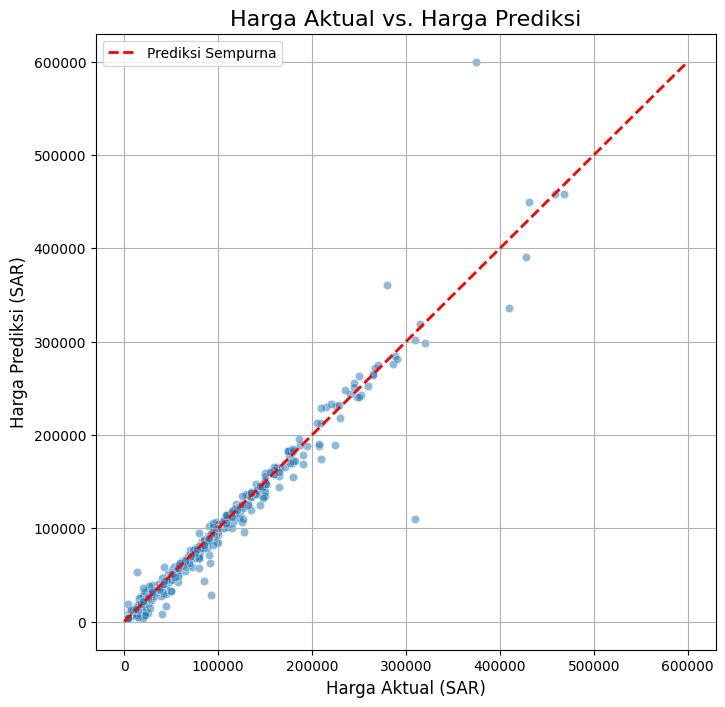

In [71]:
# Visualisasi Prediksi vs. Aktual
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test_real, y=y_pred_real, alpha=0.5)
# Tambahkan garis diagonal y=x untuk referensi
max_val = max(y_test_real.max(), y_pred_real.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', lw=2, label='Prediksi Sempurna')
plt.title('Harga Aktual vs. Harga Prediksi', fontsize=16)
plt.xlabel('Harga Aktual (SAR)', fontsize=12)
plt.ylabel('Harga Prediksi (SAR)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Secara keseluruhan, plot ini menunjukkan bahwa model Anda memiliki performa yang sangat baik. Titik-titik biru (yang mewakili setiap mobil di data uji) sebagian besar berkerumun sangat rapat di sekitar garis putus-putus merah.

- Garis Merah ("Prediksi Sempurna"): Garis ini adalah referensi di mana harga aktual sama persis dengan harga prediksi. Semakin dekat titik-titik ke garis ini, semakin akurat prediksinya.

- Pola Linear yang Kuat: Titik-titik membentuk pola linear yang jelas dan naik, yang berarti ketika harga aktual sebuah mobil meningkat, harga yang diprediksi oleh model Anda juga meningkat secara proporsional. Ini adalah tanda model yang berhasil.

Meskipun secara umum sangat baik, kita bisa melihat beberapa nuansa:

- Akurasi Tinggi pada Harga Rendah hingga Menengah: Di rentang harga di bawah 200.000 SAR, titik-titik sangat padat dan hampir menempel pada garis merah. Ini menunjukkan bahwa model Anda sangat akurat dalam memprediksi harga untuk mayoritas mobil di pasar.

- Sedikit Peningkatan Variasi pada Harga Tinggi: Di atas 200.000 SAR, titik-titik mulai sedikit lebih menyebar dari garis merah. Ini adalah hal yang sangat wajar. Ini menunjukkan bahwa model Anda sedikit lebih kesulitan (memiliki error yang sedikit lebih besar) saat memprediksi harga mobil-mobil yang sangat mahal. Ini mendukung hipotesis sebelumnya bahwa mobil-mobil unik, antik, atau mewah lebih sulit diprediksi karena harganya dipengaruhi oleh faktor-faktor yang tidak ada di dalam data.

### Feature Importance

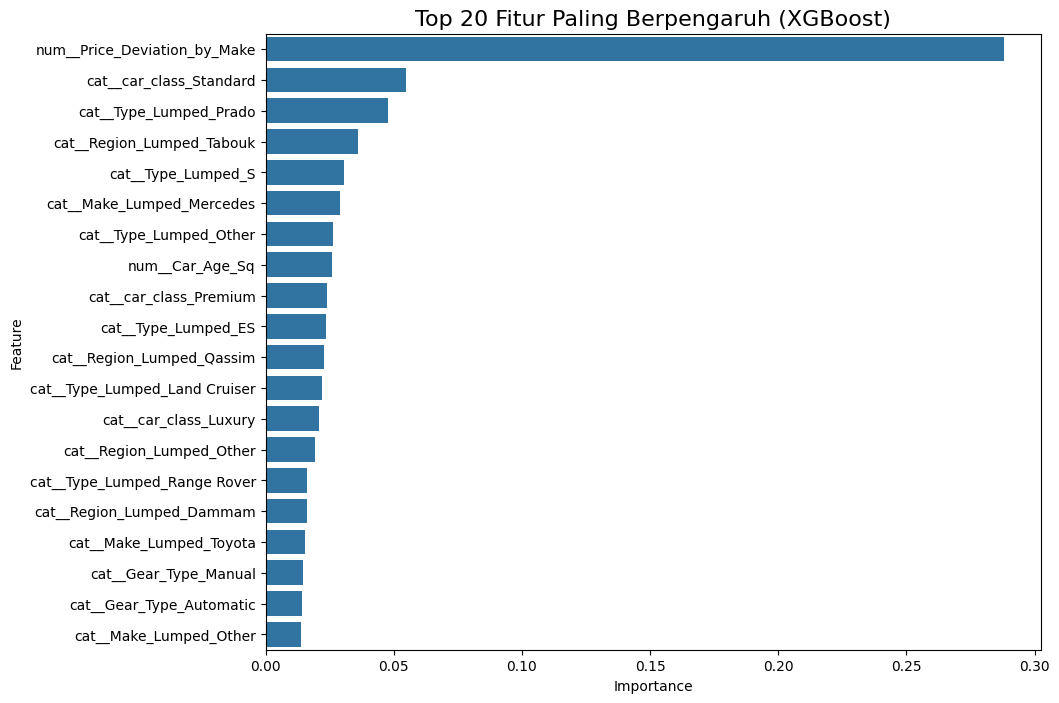

In [67]:
# Kode untuk menampilkan feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Asumsikan 'final_model' adalah pipeline Anda yang sudah dilatih
# dan 'best_model_name' berisi 'XGBoost'

# Ekstrak nama fitur dan skor importance
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importances = final_model.named_steps['regressor'].feature_importances_

# Buat DataFrame dan urutkan
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot 20 fitur teratas
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Fitur Paling Berpengaruh (XGBoost)', fontsize=16)
plt.show()


Model kami telah menemukan bahwa faktor paling signifikan dalam menentukan harga mobil bekas adalah **konteks pasarnya**, yaitu seberapa jauh harganya dari rata-rata mereknya dan apakah mobil tersebut termasuk kelas standar atau premium. Setelah itu, barulah model mempertimbangkan detail yang lebih spesifik seperti tipe mobil dan lokasinya.

## Kesimpulan dan Rekomendasi

Proyek ini berhasil mengembangkan model prediksi harga mobil bekas yang **akurat, andal, dan siap diimplementasikan** untuk mendukung strategi bisnis _Syari Mobil_. Dengan memanfaatkan data historis dan teknik _machine learning_ modern, proses penilaian harga yang sebelumnya manual dan subjektif kini dapat dilakukan secara **otomatis, cepat, dan berbasis data**.

### Evaluasi Model

Model **XGBoost** yang telah di-_tuning_ menunjukkan performa sangat baik, dengan **MAPE hanya 7,52%**. Artinya, rata-rata prediksi harga hanya meleset sedikit dari harga pasar aktual, sehingga memberikan tingkat kepercayaan tinggi bagi agen di lapangan.

Dua temuan utama yang menguatkan kinerja model adalah:

1.  **Visualisasi Harga Aktual vs. Prediksi**: Titik-titik data terkonsentrasi di sekitar garis prediksi sempurna, menunjukkan **korelasi kuat** dan konsistensi prediksi di seluruh rentang harga.
    
2.  **Faktor Penentu Harga (Feature Importance)**: Model tidak hanya akurat, tetapi juga mampu mengidentifikasi **faktor-faktor yang relevan secara bisnis**. Fitur seperti _Price Deviation by Make_ (penyimpangan harga dari rata-rata merek) dan _Mileage per Age_ (intensitas penggunaan) muncul sebagai prediktor utama, membuktikan bahwa model dapat "berpikir" layaknya penilai profesional.
    

### Rekomendasi Bisnis

Implementasi model ini dapat memberikan dampak nyata bagi _Syari Mobil_ melalui:

*   **Optimalisasi Harga Akuisisi**: Estimasi harga pasar yang presisi memungkinkan agen membeli mobil di bawah nilai pasar wajar, sehingga memaksimalkan margin keuntungan.
    
*   **Percepatan Penjualan**: Rekomendasi harga jual yang kompetitif akan mempercepat perputaran inventaris dan mengurangi biaya penyimpanan.
    
*   **Efisiensi dan Konsistensi Proses**: Prediksi harga instan menggantikan riset manual, menghemat waktu agen, dan memastikan standar penilaian harga yang seragam di seluruh perusahaan.
    

Penerapan model ini di lapangan akan menjadi **langkah strategis** yang mendorong _Syari Mobil_ menuju proses pengambilan keputusan yang **lebih cepat, tepat, dan berbasis data**.